# Working with a Corpus: Fricatives

* This notebook illustrates a measurement strategy that is a little different from the one used for vowels
* In the vowel notebook we calculated formants for every timepoint in the audio file
     * and then extracted formant measurements at points of interest
* In this notebook we identify points of interest
     * and then calculate measurements only from those selected time points


In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from fileorganize import dir_to_df
import phonlab as phon

# we will build an LDA model, so we'll load functions from sklearn.
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score

print(phon.__version__)

0.0.19


## a. Get a list of all the wav files in the corpus

In [2]:
folder = os.getcwd()
print(folder)  ## just so you know where we will be looking for the corpus

path_to_corpus = Path('./dimex')

corpus_list = dir_to_df(path_to_corpus,
               fnpat = r'(?P<subj>s\d\d\d)(?P<sentence>\d+)\.wav',    # use a regular expression to parse the filename
               addcols = ["dirname", "barename"])

/Users/kjohnson/My Drive (keithjohnson@berkeley.edu)/LSA_25


## b. Add talker info to the corpus

In [3]:
talkers = pd.DataFrame([["s008", "F"],
                        ["s019", "M"],
                        ["s038", "F"],
                        ["s050", "M"],
                        ["s072", "F"],
                        ["s090", "M"]],
                       columns = ('subj','gender'))

corpus_list = corpus_list.merge(talkers,on='subj', how='left') # add the talker information to the list
corpus_list.head()

,dirname,relpath,fname,barename,subj,sentence,gender
0,dimex,.,s00801.wav,s00801,s008,01,F
1,dimex,.,s00802.wav,s00802,s008,02,F
2,dimex,.,s00803.wav,s00803,s008,03,F
3,dimex,.,s00804.wav,s00804,s008,04,F
4,dimex,.,s00805.wav,s00805,s008,05,F


## c. Main Measurement Loop

* open each wav file, read the audio data
* open the coresponding "_phon.txt" label file and find the fricatives we want
    * calculating things like midpoint, and fricative duration
* pass the audio buffer and midpoints of the fricatives to phon.fricative() and get fricative spectrum measures
* keep the results in a dataframe
* keep some spectra for example figures

In [4]:
phone_set = ['f','s','Z','x']  # all work below will be limited to these labels in the phn files

# phones_data is an output dataframe - started here by naming the columns
phones_data = pd.DataFrame(columns=("speaker","gender","sentence","phone","time","dur","Fm","FmB","Am","mode","COG","SD","Skew","Kurtosis"))

old_speaker = ""   # keep track so we can print a progress message as the corpus is analyzed
preemph = 0.96  # a spectral tilt value to add a 6bB per octive tilt

for row in corpus_list.itertuples():   # loop through all of the wav files
    if row.subj != old_speaker:  # print a progress indicator
        old_speaker=row.subj
        print(f"\r {row.subj}", end = '') # print a progress message

    # ----------- open sound file ----------------------
    wavname = str(path_to_corpus / row.relpath / row.fname)  # construct the name of the wav file
    x,fs= phon.loadsig(wavname,chansel=[0]) 
    x2,fs = phon.prep_audio(x,fs,target_fs=22050,pre=preemph,quiet=True)

    # --------------- read the phn files -----------------
    phn = f'{row.barename}_phn.txt'
    filename = path_to_corpus / row.relpath / phn
    
    # DIMEx phn files have three columns, t1 and t2 are in milliseconds
    phdf = pd.read_csv(filename, sep=" ", header=None, skiprows=2, names=["t1", "t2", "label"])
    phdf = phon.add_context(phdf,'label',nprev=1,nnext=1)   # add phonetic context

    # make a dataframe that just has target segments
    df = phdf.query(f'label in {phone_set}').copy()  
    df['t1'] = df.t1/1000  # convert times from ms to sec
    df['t2'] = df['t2']/1000  # convert times from ms to sec
    df['midpt'] = df.loc[:, ['t1', 't2']].mean(axis='columns')  # add midpoint time values
    df['dur'] = (df.t2 - df.t1)   # duration of the segment
    df = df[df.dur>0.04]  # don't analyze anything under 40ms long
    
    # ------------ take measurements from the fricatives using phon.fricative()-----------
    for phone,mid,dur in zip(df['label'],df['midpt'],df['dur']):   # look at each fricative in the file
        
        # take the measurements
        (Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis,spec,freq) = phon.fricative(x2,fs,mid)
        
        # keep the measurements in the results dataframe
        phones_data.loc[len(phones_data.index)] = [row.subj,row.gender,row.sentence,phone,mid,
                                                   dur,Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis] 

        if phone=='f':  # keep spectral amplitudes for example spectra later
            f_spec = spec  # the example spectra are just the last instances of the
            f_Fm = Fm      # fricative that we happen to see in the corpus
            f_COG = COG
        if phone=='Z':
            Z_spec = spec
            Z_Fm = Fm
            Z_COG = COG
        if phone=='s':
            s_spec = spec
            s_Fm = Fm
            s_COG = COG
        if phone=='x':
            x_spec = spec
            x_Fm = Fm
            x_COG = COG


 s090

## d. Add a feature to the data set

In [5]:
phones_data = phones_data.replace({'phone': {'Z':'ʒ'}})  # use IPA
phone_set = ['f','s','ʒ','x']  

place_mapping = {'f':'LabioDental',
                 's':'Alveolar',
                 'ʒ':'AlveoPalatal',
                 'x':'Velar'} # code POA

phones_data['place'] = phones_data.phone.map(place_mapping)

print(phones_data.shape)

phones_data

(177, 15)


,speaker,gender,sentence,phone,time,dur,Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis,place
0,s008,F,01,s,0.505348,0.106952,9872.386364,23.903276,-5.920648,500/80%/6dB,7271.454103,2500.708971,-0.402024,-0.741337,Alveolar
1,s008,F,01,s,1.722594,0.069519,8820.000000,23.116149,-17.789650,500/80%/6dB,7694.104788,2430.864714,-0.925606,0.405105,Alveolar
2,s008,F,01,s,2.222928,0.112968,7917.954545,22.363205,-9.643506,500/80%/6dB,7229.588957,2427.287480,-0.514332,-0.483059,Alveolar
3,s008,F,01,s,2.498997,0.297460,7717.500000,22.184325,-31.889612,500/80%/6dB,6949.710592,2691.562416,-0.401623,-0.911696,Alveolar
4,s008,F,02,s,0.275401,0.089572,5913.409091,20.329117,-30.572433,500/65%/4dB,7069.570740,2699.209742,-0.637236,-0.314163,Alveolar
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172,s090,M,05,s,1.621992,0.090241,7166.250000,21.667541,-9.850146,500/80%/6dB,6928.342039,2432.045330,-0.328495,-0.655608,Alveolar
173,s090,M,05,s,2.604278,0.061498,7015.909091,21.519746,-16.490392,500/80%/6dB,7467.401620,2374.046634,-0.694662,0.026903,Alveolar
174,s090,M,05,s,3.465575,0.092914,7366.704545,21.859889,-12.660383,500/80%/6dB,6820.020997,2614.838371,-0.419967,-0.644659,Alveolar
175,s090,M,05,x,3.875668,0.096257,1854.204545,12.395472,-41.453969,500/80%/6dB,5943.459347,3222.889532,-0.086794,-1.331935,Velar


## e. Exploratory tables of the data

* look at different ways to explore the data set in tables
* How would you determine the number of talkers in the dataset?

In [6]:
print(phones_data.groupby('phone').count()['time'])

print(pd.crosstab(phones_data.phone,phones_data.speaker))

phones_data.groupby('phone').mean(numeric_only=True)

phone
f     11
s    150
x     13
ʒ      3
Name: time, dtype: int64
speaker  s008  s019  s038  s050  s072  s090
phone                                      
f           2     3     0     3     3     0
s          29    32    14    27    26    22
x           1     1     2     3     2     4
ʒ           1     0     0     1     1     0


,time,dur,Fm,FmB,Am,COG,SD,Skew,Kurtosis
phone,,,,,,,,,
f,2.142231,0.088546,6760.785124,20.959349,-37.066700,6635.832518,2947.354480,-0.354401,-1.017927
s,1.816207,0.086585,6562.213636,20.845755,-14.737222,7028.967468,2527.445592,-0.426125,-0.528496
x,2.461068,0.099255,3612.036713,15.902709,-29.650553,6254.371118,2973.687863,-0.182896,-1.114880
ʒ,1.174354,0.074643,3741.818182,17.147944,-35.328379,5641.568143,2984.330968,0.089062,-1.002770


### How many different talkers are in this data set?

In [8]:
# modify the line -- add .shape,  then add .shape[0],  
# then count how many different fricatives are in the dataset

phones_data['speaker'].unique()

6

## f. Exploratory plot of fricative spaces in Fm/Am and in COG/SD

* [ʒ] is so infrequent in this little dataset.
* Compare fricative 'spaces' with different parameters in the fricatives() output.
* Modify this code to show different acoustic parameters in phones_data

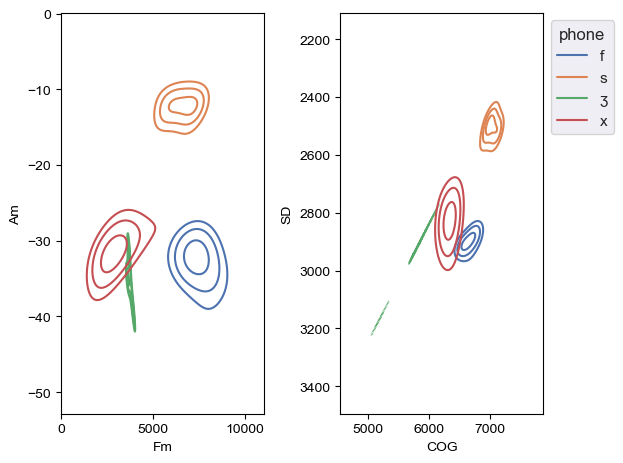

In [8]:
fig1, axs = plt.subplots(ncols=2)
sns.axes_style("darkgrid")
sns.set_theme()

fric_hue_order = ['f','s','ʒ','x']
l = [0.75,0.85,0.95]

sns.kdeplot(data=phones_data,x="Fm", y="Am", levels=l,hue="phone",
            hue_order=fric_hue_order, common_norm=False, cut=1, ax=axs[0], legend=False)

sns.kdeplot(data=phones_data,x="COG", y="SD", levels=l, hue="phone",
            hue_order=fric_hue_order, common_norm=False, cut=1, ax=axs[1])
axs[1].invert_yaxis()

sns.move_legend(axs[1], "upper left", bbox_to_anchor=(1, 1))  # move the legend out of the figure
fig1.tight_layout()

#  fig1.savefig("dimex_spaces.png", dpi=300.0, pad_inches=0.1)

## g. looking at how measures relate to each other 

- would like uncorrelated measures

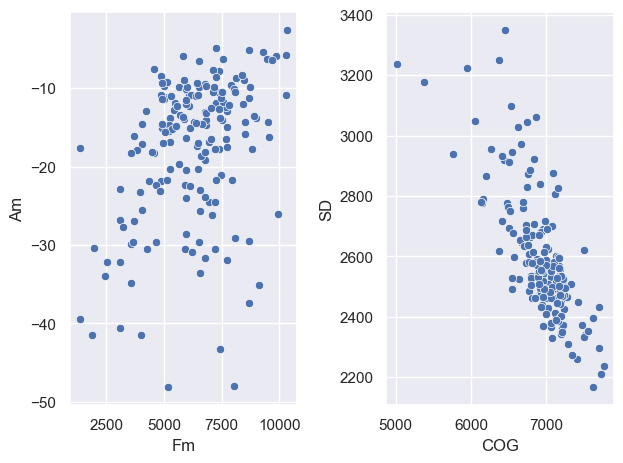

In [9]:
fig, axs = plt.subplots(ncols=2)
sns.scatterplot(data=phones_data,x="Fm",y="Am",ax=axs[0])
sns.scatterplot(data=phones_data,x="COG",y="SD",ax=axs[1])
fig.tight_layout()

## h. Example spectra

[f]: Fm = 3107, COG=6057
[s]: Fm = 7717, COG=7181
[Z]: Fm = 4009, COG=6146
[x]: Fm = 1854, COG=5943


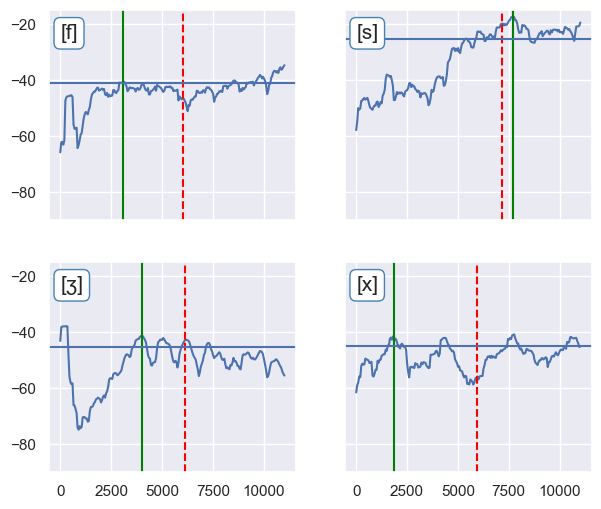

In [10]:
fig2, axs = plt.subplots(ncols=2,nrows=2,figsize=(7, 6))

# the top left panel

axs[0][0].plot(freq,f_spec)               # the spectrum
axs[0][0].axvline(f_Fm,color='green')     # the green line
axs[0][0].axvline(f_COG, color='red',linestyle='dashed')  # the dashed red line
axs[0][0].axhline(np.min(f_spec) + (np.max(f_spec)-np.min(f_spec))*0.80)  # the horizontal line
axs[0][0].text(0, -20, "[f]", ha="left", va="top", size=15,               # the text label
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))
print(f'[f]: Fm = {f_Fm:.0f}, COG={f_COG:.0f}')

# the top right panel

axs[0][1].plot(freq,s_spec)
axs[0][1].axvline(s_Fm,color='green')
axs[0][1].axvline(s_COG, color='red',linestyle='dashed')
axs[0][1].axhline(np.min(s_spec) + (np.max(s_spec)-np.min(s_spec))*0.8) 
axs[0][1].text(0, -20, "[s]", 
            ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))
print(f'[s]: Fm = {s_Fm:.0f}, COG={s_COG:.0f}')

# the bottom left panel

axs[1][0].plot(freq,Z_spec)
axs[1][0].axvline(Z_Fm,color='green')
axs[1][0].axvline(Z_COG, color='red',linestyle='dashed')
axs[1][0].axhline(np.min(Z_spec) + (np.max(Z_spec)-np.min(Z_spec))*0.8)
axs[1][0].text(0, -20, "[ʒ]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))
print(f'[Z]: Fm = {Z_Fm:.0f}, COG={Z_COG:.0f}')

# the bottom right panel

axs[1][1].plot(freq,x_spec)
axs[1][1].axvline(x_Fm,color='green')
axs[1][1].axvline(x_COG, color='red',linestyle='dashed')
axs[1][1].axhline(np.min(x_spec) + (np.max(x_spec)-np.min(x_spec))*0.8)
axs[1][1].text(0, -20, "[x]", ha="left", va="top", size=15,
            bbox=dict(boxstyle="round",fc="white", ec="steelblue", lw=1))
print(f'[x]: Fm = {x_Fm:.0f}, COG={x_COG:.0f}')

axs[0][0].set_ylim(bottom=-90,top=-15)  # set the amplitude scale to be the same
axs[0][1].set_ylim(bottom=-90,top=-15)
axs[1][0].set_ylim(bottom=-90,top=-15)
axs[1][1].set_ylim(bottom=-90,top=-15)

axs[0][0].xaxis.set_ticklabels([])  # remove some tick labels
axs[0][1].yaxis.set_ticklabels([])
axs[0][1].xaxis.set_ticklabels([])
axs[1][1].yaxis.set_ticklabels([])

fig2.savefig('dimex_spectra.png',dpi=300.0)

## i. Fit LDA models with different parameter sets.

* Take an equal number of instances of each fricative category using the pandas.sample() function
* Fitting different LDA models, using different parameters from the phones_data set
* and using cross validation to measure how good the models are.  (chance is 0.25 accuracy)
* This data set is too small for this to be a legit thing to do, but I thought I'd show it anyway for future reference.

model1: 0.70 accuracy with a standard deviation of 0.13
model2: 0.88 accuracy with a standard deviation of 0.19


<Axes: ylabel='Density'>

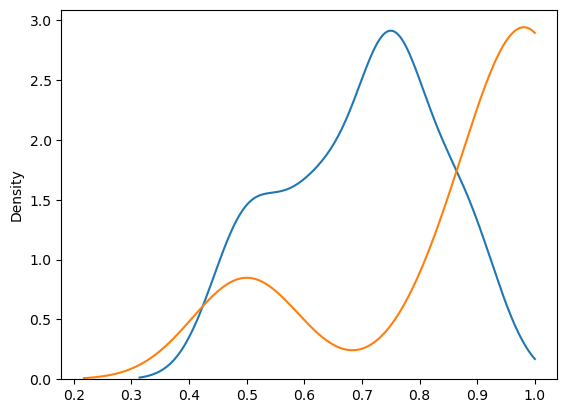

In [17]:
# select a test set randomly, each phone is equally likely

test_data = phones_data.groupby('phone').sample(10,replace=True)  # such a small data set!


X1 = test_data[['Fm','Am','dur']].to_numpy()
LDA_model1 = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto",n_components=1)
scores1 = cross_val_score(LDA_model1, X1, test_data.phone, cv=5)  # 5 fold cross-validation
print("model1: %0.2f accuracy with a standard deviation of %0.2f" % (scores1.mean(), scores1.std()))

X2 = test_data[['COG','SD','dur']].to_numpy()
LDA_model2 = LinearDiscriminantAnalysis(solver="eigen", shrinkage="auto",n_components=1)
scores2 = cross_val_score(LDA_model2, X2, test_data.phone, cv=5)  # 5 fold cross-validation
print("model2: %0.2f accuracy with a standard deviation of %0.2f" % (scores2.mean(), scores2.std()))

sns.kdeplot(np.array(scores1),clip=(0,1),bw_adjust=0.6)
sns.kdeplot(np.array(scores2),clip=(0,1),bw_adjust=0.6)